DLinear Model Experiment for Walmart Sales Forecasting
Final Project - ML Course

This notebook implements and experiments with DLinear (Decomposition Linear)
for time series forecasting on Walmart sales data.

## CELL 1: Setup and Installations

Install required packages

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install mlflow
!pip install dagshub
!pip install joblib
!pip install scikit-learn
!pip install pandas numpy matplotlib seaborn
!pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.2 MB/s e

## CELL 2: Mount Google Drive

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ml-final/ML-Final')

Mounted at /content/drive


## CELL 3: Import Libraries

Import required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PyTorch and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# Sklearn utilities
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import joblib

# MLflow and experiment tracking
import mlflow
import mlflow.pytorch
import dagshub

# System utilities
import sys
sys.path.append('.')
import pickle
from typing import Tuple, Dict, List

## CELL 4: Initialize MLflow and Load Data

Initialize MLflow experiment tracking

In [4]:
dagshub.init(repo_owner='egval20', repo_name='ML-Final', mlflow=True)
mlflow.set_experiment("DLinear")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=01dbee33-bb20-4f6c-8e34-20c48120f9a2&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=1e6fbef859acd348f59b4370f4644a745dad5bd3661b662564429d3c202c39c1




Accessing as egval20

Initialized MLflow to track repo "egval20/ML-Final"

Repository egval20/ML-Final initialized!

2025/07/06 16:03:02 INFO mlflow.tracking.fluent: Experiment with name 'DLinear' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6f04d2ae93084a04a86672a891266065', creation_time=1751817782215, experiment_id='8', last_update_time=1751817782215, lifecycle_stage='active', name='DLinear', tags={}>

## CELL 5: Load Preprocessing Pipeline and Data

Load preprocessing pipeline and data

In [5]:
from data_preprocessing_pipeline import *

def get_model_ready_data(pipeline_path='preprocessing_pipeline.pkl'):
    pipeline = joblib.load(pipeline_path)
    def preprocess_for_model(raw_data):
        return pipeline.transform(raw_data)
    return preprocess_for_model, pipeline

# Load preprocessing pipeline
preprocess_fn, loaded_pipeline = get_model_ready_data()

# Load raw data
print("Loading raw data...")
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"Date range - Train: {train_raw['Date'].min()} to {train_raw['Date'].max()}")
print(f"Date range - Test: {test_raw['Date'].min()} to {test_raw['Date'].max()}")

Loading raw data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Date range - Train: 2010-02-05 to 2012-10-26
Date range - Test: 2012-11-02 to 2013-07-26


## CELL 6: Apply Preprocessing

Apply preprocessing pipeline

In [6]:
train_processed = preprocess_fn(train_raw)
test_processed = preprocess_fn(test_raw)

# Drop lag features as suggested in ARIMA notebook
lag_columns_to_drop = [
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_52',
    'Sales_MA_4', 'Sales_MA_8', 'Sales_MA_12',
    'Sales_STD_4', 'Sales_STD_8', 'Sales_STD_12'
]

def drop_lag_features(data, columns_to_drop):
    existing_cols = [col for col in columns_to_drop if col in data.columns]
    cleaned_data = data.drop(columns=existing_cols)
    print(f"Dropped {len(existing_cols)} lag/MA columns")
    return cleaned_data

train_processed_clean = drop_lag_features(train_processed, lag_columns_to_drop)
test_processed_clean = drop_lag_features(test_processed, lag_columns_to_drop)

print(f"Cleaned train shape: {train_processed_clean.shape}")
print(f"Cleaned test shape: {test_processed_clean.shape}")

Dropped 12 lag/MA columns
Dropped 12 lag/MA columns
Cleaned train shape: (421570, 52)
Cleaned test shape: (115064, 51)


## CELL 7: DLinear Model Architecture

DLinear Model Implementation

In [7]:
class MovingAvgFilter(nn.Module):
    """Moving average filter for series decomposition"""
    def __init__(self, kernel_size):
        super(MovingAvgFilter, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        # x: batch_size x seq_len x n_features
        # Pad the sequence
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)

        # Apply moving average (need to transpose for AvgPool1d)
        x = x.transpose(1, 2)  # batch_size x n_features x seq_len
        x = self.avg(x)
        x = x.transpose(1, 2)  # batch_size x seq_len x n_features

        return x


class SeriesDecomposition(nn.Module):
    """Series decomposition into trend and seasonal components"""
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAvgFilter(kernel_size)

    def forward(self, x):
        trend = self.moving_avg(x)
        seasonal = x - trend
        return seasonal, trend


class DLinear(nn.Module):
    """DLinear: Decomposition Linear Model for Time Series Forecasting"""
    def __init__(self,
                 seq_len: int,
                 pred_len: int,
                 n_features: int,
                 moving_avg_kernel: int = 25,
                 individual: bool = False):
        """
        Args:
            seq_len: Input sequence length
            pred_len: Prediction sequence length
            n_features: Number of features
            moving_avg_kernel: Kernel size for moving average
            individual: Whether to use individual feature processing
        """
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.individual = individual

        # Series decomposition
        self.decomposition = SeriesDecomposition(moving_avg_kernel)

        if self.individual:
            # Individual linear layers for each feature
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(n_features):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            # Shared linear layers
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: batch_size x seq_len x n_features
        seasonal_init, trend_init = self.decomposition(x)

        if self.individual:
            seasonal_output = torch.zeros([x.size(0), self.pred_len, x.size(2)],
                                        dtype=x.dtype, device=x.device)
            trend_output = torch.zeros([x.size(0), self.pred_len, x.size(2)],
                                     dtype=x.dtype, device=x.device)

            for i in range(x.size(2)):
                seasonal_output[:, :, i] = self.Linear_Seasonal[i](seasonal_init[:, :, i])
                trend_output[:, :, i] = self.Linear_Trend[i](trend_init[:, :, i])
        else:
            # Permute for linear layer
            seasonal_init = seasonal_init.permute(0, 2, 1)  # batch x n_features x seq_len
            trend_init = trend_init.permute(0, 2, 1)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

            # Permute back
            seasonal_output = seasonal_output.permute(0, 2, 1)  # batch x pred_len x n_features
            trend_output = trend_output.permute(0, 2, 1)

        predictions = seasonal_output + trend_output
        return predictions

## CELL 8: Data Preparation for DLinear

Prepare time series data for DLinear

In [8]:
class TimeSeriesDataPreparation:
    def __init__(self, seq_len=52, pred_len=8, stride=1):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.stride = stride
        self.scalers = {}

    def prepare_hierarchical_data(self, data, level='total'):
        """Prepare data at different hierarchical levels"""
        data = data.copy()
        data['Date'] = pd.to_datetime(data['Date'])

        if level == 'total':
            # Total sales across all stores and departments
            agg_data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
            agg_data = agg_data.sort_values('Date')
            return agg_data
        elif level == 'store':
            # Sales by store
            store_dict = {}
            for store in data['Store'].unique():
                store_data = data[data['Store'] == store]
                store_agg = store_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
                store_agg = store_agg.sort_values('Date')
                store_dict[store] = store_agg
            return store_dict
        elif level == 'dept':
            # Sales by department
            dept_dict = {}
            for dept in data['Dept'].unique():
                dept_data = data[data['Dept'] == dept]
                dept_agg = dept_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
                dept_agg = dept_agg.sort_values('Date')
                dept_dict[dept] = dept_agg
            return dept_dict

    def create_sequences(self, data, target_col='Weekly_Sales'):
        """Create sequences for time series prediction"""
        sequences = []
        targets = []

        values = data[target_col].values

        for i in range(0, len(values) - self.seq_len - self.pred_len + 1, self.stride):
            seq = values[i:i + self.seq_len]
            target = values[i + self.seq_len:i + self.seq_len + self.pred_len]

            sequences.append(seq)
            targets.append(target)

        return np.array(sequences), np.array(targets)

    def prepare_features(self, data, feature_cols=None):
        """Prepare additional features for multivariate time series"""
        if feature_cols is None:
            return None

        feature_sequences = []

        for i in range(0, len(data) - self.seq_len - self.pred_len + 1, self.stride):
            seq = data[feature_cols].iloc[i:i + self.seq_len].values
            feature_sequences.append(seq)

        return np.array(feature_sequences)

## CELL 9: Dataset Class for PyTorch

Custom Dataset class for time series

In [9]:
class WalmartTimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets, features=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.features = torch.FloatTensor(features) if features is not None else None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.features is not None:
            # Combine sequences with features
            seq_with_features = torch.cat([
                self.sequences[idx].unsqueeze(-1),
                self.features[idx]
            ], dim=-1)
            return seq_with_features, self.targets[idx]
        else:
            return self.sequences[idx].unsqueeze(-1), self.targets[idx]

## CELL 10: Training Functions

Training and evaluation functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_x)

        # Calculate loss (only on target feature)
        loss = criterion(predictions[:, :, 0], batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions_list = []
    targets_list = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model(batch_x)
            loss = criterion(predictions[:, :, 0], batch_y)

            total_loss += loss.item() * batch_x.size(0)

            predictions_list.append(predictions[:, :, 0].cpu().numpy())
            targets_list.append(batch_y.cpu().numpy())

    predictions = np.concatenate(predictions_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)

    mae = mean_absolute_error(targets.flatten(), predictions.flatten())
    rmse = np.sqrt(mean_squared_error(targets.flatten(), predictions.flatten()))

    return total_loss / len(dataloader.dataset), mae, rmse, predictions, targets

## CELL 11: Start MLflow Run - Data Cleaning

Log data cleaning process

In [11]:
with mlflow.start_run(run_name="DLinear_Cleaning"):
    mlflow.log_param("columns_to_drop_count", len(lag_columns_to_drop))
    mlflow.log_param("columns_to_drop", lag_columns_to_drop)
    mlflow.log_metric("original_train_rows", train_processed.shape[0])
    mlflow.log_metric("original_train_cols", train_processed.shape[1])
    mlflow.log_metric("final_train_rows", train_processed_clean.shape[0])
    mlflow.log_metric("final_train_cols", train_processed_clean.shape[1])

🏃 View run DLinear_Cleaning at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8/runs/4290fb2f6eb5440cbfc049c552cbdbae
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8


## CELL 12: Prepare Data for DLinear

Prepare data for DLinear training

In [12]:
# Initialize data preparation
data_prep = TimeSeriesDataPreparation(seq_len=52, pred_len=8, stride=1)

# Prepare total sales data
print("Preparing hierarchical time series data...")
total_sales_data = data_prep.prepare_hierarchical_data(train_processed_clean, level='total')
print(f"Total sales data shape: {total_sales_data.shape}")

# Create train/validation split
train_size = int(0.8 * len(total_sales_data))
train_data = total_sales_data[:train_size]
val_data = total_sales_data[train_size:]

print(f"Train period: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Val period: {val_data['Date'].min()} to {val_data['Date'].max()}")

# Scale the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['Weekly_Sales']])
val_scaled = scaler.transform(val_data[['Weekly_Sales']])

# Create full scaled dataset
full_scaled = np.concatenate([train_scaled, val_scaled])
full_data = total_sales_data.copy()
full_data['Weekly_Sales_Scaled'] = full_scaled.flatten()

# Create sequences
train_sequences, train_targets = data_prep.create_sequences(
    train_data, target_col='Weekly_Sales'
)
val_sequences, val_targets = data_prep.create_sequences(
    pd.concat([train_data.tail(data_prep.seq_len), val_data]),
    target_col='Weekly_Sales'
)

# Scale sequences
train_sequences_scaled = scaler.transform(train_sequences.reshape(-1, 1)).reshape(train_sequences.shape)
train_targets_scaled = scaler.transform(train_targets.reshape(-1, 1)).reshape(train_targets.shape)
val_sequences_scaled = scaler.transform(val_sequences.reshape(-1, 1)).reshape(val_sequences.shape)
val_targets_scaled = scaler.transform(val_targets.reshape(-1, 1)).reshape(val_targets.shape)

print(f"Train sequences shape: {train_sequences_scaled.shape}")
print(f"Train targets shape: {train_targets_scaled.shape}")
print(f"Val sequences shape: {val_sequences_scaled.shape}")
print(f"Val targets shape: {val_targets_scaled.shape}")

Preparing hierarchical time series data...
Total sales data shape: (143, 2)
Train period: 2010-02-05 00:00:00 to 2012-04-06 00:00:00
Val period: 2012-04-13 00:00:00 to 2012-10-26 00:00:00
Train sequences shape: (55, 52)
Train targets shape: (55, 8)
Val sequences shape: (22, 52)
Val targets shape: (22, 8)


## CELL 13: Create DataLoaders

Create PyTorch DataLoaders

In [13]:
# Create datasets
train_dataset = WalmartTimeSeriesDataset(train_sequences_scaled, train_targets_scaled)
val_dataset = WalmartTimeSeriesDataset(val_sequences_scaled, val_targets_scaled)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 2
Number of validation batches: 1


## CELL 14: Train Baseline DLinear Model

Train baseline DLinear model

Using device: cuda
=== Training Baseline DLinear Model ===
Epoch [10/100] - Train Loss: 1.1003, Val Loss: 0.3172, Val MAE: 0.4624, Val RMSE: 0.5632
Epoch [20/100] - Train Loss: 0.8812, Val Loss: 0.2464, Val MAE: 0.4062, Val RMSE: 0.4963
Epoch [30/100] - Train Loss: 0.7232, Val Loss: 0.2078, Val MAE: 0.3713, Val RMSE: 0.4559
Epoch [40/100] - Train Loss: 0.6084, Val Loss: 0.1879, Val MAE: 0.3499, Val RMSE: 0.4335
Epoch [50/100] - Train Loss: 0.5213, Val Loss: 0.1802, Val MAE: 0.3378, Val RMSE: 0.4245
Epoch [60/100] - Train Loss: 0.4540, Val Loss: 0.1814, Val MAE: 0.3349, Val RMSE: 0.4259
Early stopping at epoch 63

Baseline Model Final Performance:
MAE: 2021021.88
RMSE: 2548342.56


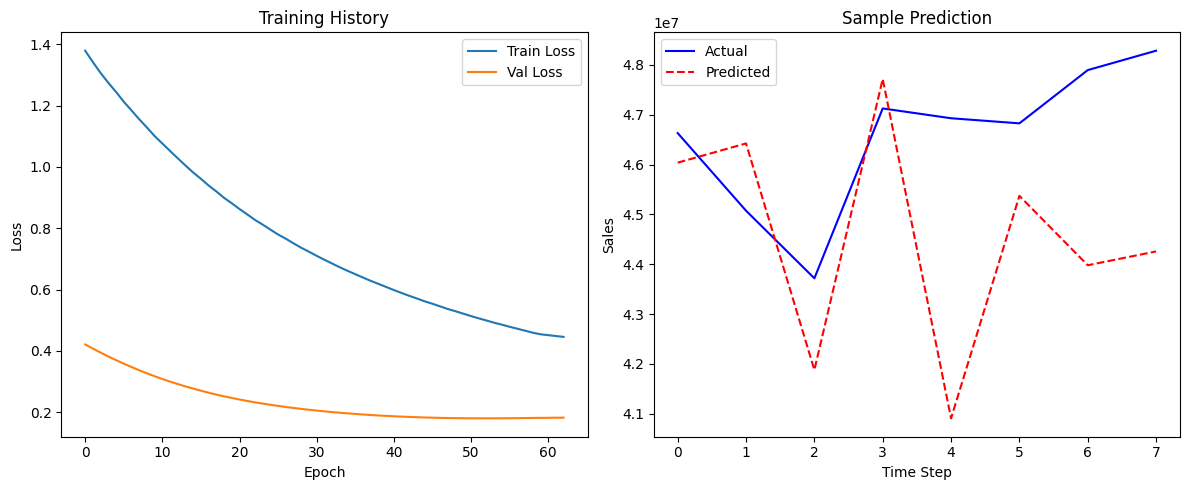

🏃 View run DLinear_Baseline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8/runs/a14ecac2e51b4299b387a34c9a88a2af
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

with mlflow.start_run(run_name="DLinear_Baseline"):
    print("=== Training Baseline DLinear Model ===")

    # Model parameters
    seq_len = 52
    pred_len = 8
    n_features = 1  # Univariate for now
    moving_avg_kernel = 25

    # Log parameters
    mlflow.log_param("model_type", "DLinear_Baseline")
    mlflow.log_param("seq_len", seq_len)
    mlflow.log_param("pred_len", pred_len)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("moving_avg_kernel", moving_avg_kernel)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("n_epochs", 100)

    # Initialize model
    model = DLinear(
        seq_len=seq_len,
        pred_len=pred_len,
        n_features=n_features,
        moving_avg_kernel=moving_avg_kernel,
        individual=False
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Training loop
    n_epochs = 100
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_mae, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'dlinear_baseline_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('dlinear_baseline_best.pth'))

    # Final evaluation
    val_loss, val_mae, val_rmse, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

    # Inverse transform predictions for actual scale
    val_preds_original = scaler.inverse_transform(val_preds.reshape(-1, 1)).reshape(val_preds.shape)
    val_targets_original = scaler.inverse_transform(val_targets.reshape(-1, 1)).reshape(val_targets.shape)

    final_mae = mean_absolute_error(val_targets_original.flatten(), val_preds_original.flatten())
    final_rmse = np.sqrt(mean_squared_error(val_targets_original.flatten(), val_preds_original.flatten()))

    print(f"\nBaseline Model Final Performance:")
    print(f"MAE: {final_mae:.2f}")
    print(f"RMSE: {final_rmse:.2f}")

    # Log metrics
    mlflow.log_metric("val_mae", final_mae)
    mlflow.log_metric("val_rmse", final_rmse)
    mlflow.log_metric("best_val_loss", best_val_loss)
    mlflow.log_metric("final_epoch", epoch + 1)

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Plot a sample prediction
    sample_idx = 0
    plt.plot(range(pred_len), val_targets_original[sample_idx], 'b-', label='Actual')
    plt.plot(range(pred_len), val_preds_original[sample_idx], 'r--', label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Sales')
    plt.title('Sample Prediction')
    plt.legend()

    plt.tight_layout()
    plt.savefig('dlinear_baseline_results.png')
    plt.show()

    # Log artifacts
    mlflow.log_artifact('dlinear_baseline_results.png')
    mlflow.log_artifact('dlinear_baseline_best.pth')

    # Save scaler
    joblib.dump(scaler, 'dlinear_scaler.pkl')
    mlflow.log_artifact('dlinear_scaler.pkl')

## CELL 15: Train DLinear with Individual Features

Train DLinear with individual feature processing

In [15]:
with mlflow.start_run(run_name="DLinear_Individual"):
    print("\n=== Training DLinear with Individual Features ===")

    # Log parameters
    mlflow.log_param("model_type", "DLinear_Individual")
    mlflow.log_param("seq_len", seq_len)
    mlflow.log_param("pred_len", pred_len)
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("moving_avg_kernel", moving_avg_kernel)
    mlflow.log_param("individual", True)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("n_epochs", 100)

    # Initialize model with individual processing
    model_individual = DLinear(
        seq_len=seq_len,
        pred_len=pred_len,
        n_features=n_features,
        moving_avg_kernel=moving_avg_kernel,
        individual=True
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_individual.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Training loop
    n_epochs = 100
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(n_epochs):
        # Train
        train_loss = train_epoch(model_individual, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_mae, val_rmse, _, _ = evaluate(model_individual, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model_individual.state_dict(), 'dlinear_individual_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model_individual.load_state_dict(torch.load('dlinear_individual_best.pth'))

    # Final evaluation
    val_loss, val_mae, val_rmse, val_preds, val_targets = evaluate(model_individual, val_loader, criterion, device)

    # Inverse transform
    val_preds_original = scaler.inverse_transform(val_preds.reshape(-1, 1)).reshape(val_preds.shape)
    val_targets_original = scaler.inverse_transform(val_targets.reshape(-1, 1)).reshape(val_targets.shape)

    final_mae_individual = mean_absolute_error(val_targets_original.flatten(), val_preds_original.flatten())
    final_rmse_individual = np.sqrt(mean_squared_error(val_targets_original.flatten(), val_preds_original.flatten()))

    print(f"\nIndividual Model Final Performance:")
    print(f"MAE: {final_mae_individual:.2f}")
    print(f"RMSE: {final_rmse_individual:.2f}")

    # Log metrics
    mlflow.log_metric("val_mae", final_mae_individual)
    mlflow.log_metric("val_rmse", final_rmse_individual)
    mlflow.log_metric("best_val_loss", best_val_loss)

    # Log artifacts
    mlflow.log_artifact('dlinear_individual_best.pth')


=== Training DLinear with Individual Features ===
Epoch [10/100] - Train Loss: 1.0195, Val Loss: 0.2540, Val MAE: 0.4165, Val RMSE: 0.5040
Epoch [20/100] - Train Loss: 0.8102, Val Loss: 0.2007, Val MAE: 0.3655, Val RMSE: 0.4480
Epoch [30/100] - Train Loss: 0.6654, Val Loss: 0.1759, Val MAE: 0.3401, Val RMSE: 0.4194
Epoch [40/100] - Train Loss: 0.5602, Val Loss: 0.1685, Val MAE: 0.3285, Val RMSE: 0.4105
Epoch [50/100] - Train Loss: 0.4942, Val Loss: 0.1708, Val MAE: 0.3298, Val RMSE: 0.4132
Early stopping at epoch 50

Individual Model Final Performance:
MAE: 1973808.75
RMSE: 2466683.69
🏃 View run DLinear_Individual at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8/runs/af99acdc6a1d4113afcc9ea1d9439fdc
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8


## CELL 16: Hyperparameter Search

Hyperparameter search for DLinear

In [16]:
with mlflow.start_run(run_name="DLinear_Hyperparameter_Search"):
    print("\n=== DLinear Hyperparameter Search ===")

    # Define hyperparameter search space
    param_grid = {
        'seq_len': [26, 52, 78],
        'moving_avg_kernel': [13, 25, 37],
        'learning_rate': [0.001, 0.0005, 0.0001],
        'individual': [True, False]
    }

    best_mae = float('inf')
    best_params = {}

    # Simplified grid search (testing only a subset)
    for seq_len_hp in [52]:
        for kernel in [13, 25]:
            for lr in [0.001, 0.0005]:
                for individual in [True, False]:
                    print(f"\nTesting: seq_len={seq_len_hp}, kernel={kernel}, lr={lr}, individual={individual}")

                    # Prepare data with new sequence length
                    data_prep_hp = TimeSeriesDataPreparation(seq_len=seq_len_hp, pred_len=8)

                    # Create sequences
                    train_seq_hp, train_tgt_hp = data_prep_hp.create_sequences(
                        train_data, target_col='Weekly_Sales'
                    )
                    val_seq_hp, val_tgt_hp = data_prep_hp.create_sequences(
                        pd.concat([train_data.tail(seq_len_hp), val_data]),
                        target_col='Weekly_Sales'
                    )

                    # Scale
                    train_seq_scaled_hp = scaler.transform(train_seq_hp.reshape(-1, 1)).reshape(train_seq_hp.shape)
                    train_tgt_scaled_hp = scaler.transform(train_tgt_hp.reshape(-1, 1)).reshape(train_tgt_hp.shape)
                    val_seq_scaled_hp = scaler.transform(val_seq_hp.reshape(-1, 1)).reshape(val_seq_hp.shape)
                    val_tgt_scaled_hp = scaler.transform(val_tgt_hp.reshape(-1, 1)).reshape(val_tgt_hp.shape)

                    # Create datasets
                    train_dataset_hp = WalmartTimeSeriesDataset(train_seq_scaled_hp, train_tgt_scaled_hp)
                    val_dataset_hp = WalmartTimeSeriesDataset(val_seq_scaled_hp, val_tgt_scaled_hp)

                    # Create dataloaders
                    train_loader_hp = DataLoader(train_dataset_hp, batch_size=32, shuffle=True)
                    val_loader_hp = DataLoader(val_dataset_hp, batch_size=32, shuffle=False)

                    try:
                        # Initialize model
                        model_hp = DLinear(
                            seq_len=seq_len_hp,
                            pred_len=8,
                            n_features=1,
                            moving_avg_kernel=kernel,
                            individual=individual
                        ).to(device)

                        # Training
                        criterion = nn.MSELoss()
                        optimizer = optim.Adam(model_hp.parameters(), lr=lr)

                        # Quick training for hyperparameter search
                        best_val_mae_hp = float('inf')
                        for epoch in range(30):  # Fewer epochs for search
                            train_loss = train_epoch(model_hp, train_loader_hp, criterion, optimizer, device)
                            val_loss, val_mae, _, _, _ = evaluate(model_hp, val_loader_hp, criterion, device)

                            if val_mae < best_val_mae_hp:
                                best_val_mae_hp = val_mae

                        print(f"Best VAL MAE: {best_val_mae_hp:.4f}")

                        # Track best model
                        if best_val_mae_hp < best_mae:
                            best_mae = best_val_mae_hp
                            best_params = {
                                'seq_len': seq_len_hp,
                                'moving_avg_kernel': kernel,
                                'learning_rate': lr,
                                'individual': individual
                            }

                        # Log trial
                        mlflow.log_metric(f"mae_seq{seq_len_hp}_k{kernel}_lr{lr}_ind{individual}", best_val_mae_hp)

                    except Exception as e:
                        print(f"Error in trial: {e}")
                        continue

    print(f"\nBest parameters: {best_params}")
    print(f"Best MAE: {best_mae:.4f}")

    # Log best parameters
    for param, value in best_params.items():
        mlflow.log_param(f"best_{param}", value)
    mlflow.log_metric("best_mae", best_mae)


=== DLinear Hyperparameter Search ===

Testing: seq_len=52, kernel=13, lr=0.001, individual=True
Best VAL MAE: 0.3651

Testing: seq_len=52, kernel=13, lr=0.001, individual=False
Best VAL MAE: 0.3121

Testing: seq_len=52, kernel=13, lr=0.0005, individual=True
Best VAL MAE: 0.3767

Testing: seq_len=52, kernel=13, lr=0.0005, individual=False
Best VAL MAE: 0.3632

Testing: seq_len=52, kernel=25, lr=0.001, individual=True
Best VAL MAE: 0.3721

Testing: seq_len=52, kernel=25, lr=0.001, individual=False
Best VAL MAE: 0.3423

Testing: seq_len=52, kernel=25, lr=0.0005, individual=True
Best VAL MAE: 0.4314

Testing: seq_len=52, kernel=25, lr=0.0005, individual=False
Best VAL MAE: 0.4041

Best parameters: {'seq_len': 52, 'moving_avg_kernel': 13, 'learning_rate': 0.001, 'individual': False}
Best MAE: 0.3121
🏃 View run DLinear_Hyperparameter_Search at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8/runs/75c3c20989164fa3a7e74d85546fcc7d
🧪 View experiment at: https://dagshub.com/egval20

## CELL 17: Train Multivariate DLinear

Train multivariate DLinear with additional features

In [17]:
with mlflow.start_run(run_name="DLinear_Multivariate"):
    print("\n=== Training Multivariate DLinear ===")

    # Select relevant features for multivariate forecasting
    feature_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']

    # Prepare multivariate data
    # Aggregate features to match total sales aggregation
    total_data_with_features = train_processed_clean.copy()
    total_data_with_features['Date'] = pd.to_datetime(total_data_with_features['Date'])

    # Aggregate by date
    agg_dict = {'Weekly_Sales': 'sum'}
    for col in feature_cols:
        if col == 'IsHoliday':
            agg_dict[col] = 'max'  # If any store has holiday, mark as holiday
        else:
            agg_dict[col] = 'mean'  # Average across stores

    multivar_data = total_data_with_features.groupby('Date').agg(agg_dict).reset_index()
    multivar_data = multivar_data.sort_values('Date')

    print(f"Multivariate data shape: {multivar_data.shape}")

    # Split data
    train_size_mv = int(0.8 * len(multivar_data))
    train_data_mv = multivar_data[:train_size_mv]
    val_data_mv = multivar_data[train_size_mv:]

    # Scale all features
    feature_scalers = {}
    train_features_scaled = {}
    val_features_scaled = {}

    for col in ['Weekly_Sales'] + feature_cols:
        scaler_feat = StandardScaler()
        train_features_scaled[col] = scaler_feat.fit_transform(train_data_mv[[col]])
        val_features_scaled[col] = scaler_feat.transform(val_data_mv[[col]])
        feature_scalers[col] = scaler_feat

    # Create sequences with features
    n_features_mv = len(feature_cols) + 1  # +1 for target

    # Prepare sequences
    seq_len_mv = 52
    pred_len_mv = 8

    def create_multivariate_sequences(data_dict, seq_len, pred_len):
        n_samples = len(data_dict['Weekly_Sales']) - seq_len - pred_len + 1
        sequences = np.zeros((n_samples, seq_len, n_features_mv))
        targets = np.zeros((n_samples, pred_len))

        for i in range(n_samples):
            # Target is always Weekly_Sales
            targets[i] = data_dict['Weekly_Sales'][i + seq_len:i + seq_len + pred_len, 0]

            # Features include target and additional features
            for j, col in enumerate(['Weekly_Sales'] + feature_cols):
                sequences[i, :, j] = data_dict[col][i:i + seq_len, 0]

        return sequences, targets

    train_seq_mv, train_tgt_mv = create_multivariate_sequences(
        train_features_scaled, seq_len_mv, pred_len_mv
    )

    # For validation, we need to include some training data for context
    combined_features_scaled = {}
    for col in ['Weekly_Sales'] + feature_cols:
        combined_features_scaled[col] = np.vstack([
            train_features_scaled[col][-seq_len_mv:],
            val_features_scaled[col]
        ])

    val_seq_mv, val_tgt_mv = create_multivariate_sequences(
        combined_features_scaled, seq_len_mv, pred_len_mv
    )

    print(f"Multivariate train sequences shape: {train_seq_mv.shape}")
    print(f"Multivariate val sequences shape: {val_seq_mv.shape}")

    # Create datasets and dataloaders
    train_dataset_mv = TensorDataset(
        torch.FloatTensor(train_seq_mv),
        torch.FloatTensor(train_tgt_mv)
    )
    val_dataset_mv = TensorDataset(
        torch.FloatTensor(val_seq_mv),
        torch.FloatTensor(val_tgt_mv)
    )

    train_loader_mv = DataLoader(train_dataset_mv, batch_size=32, shuffle=True)
    val_loader_mv = DataLoader(val_dataset_mv, batch_size=32, shuffle=False)

    # Log parameters
    mlflow.log_param("model_type", "DLinear_Multivariate")
    mlflow.log_param("seq_len", seq_len_mv)
    mlflow.log_param("pred_len", pred_len_mv)
    mlflow.log_param("n_features", n_features_mv)
    mlflow.log_param("feature_cols", feature_cols)

    # Initialize multivariate model
    model_mv = DLinear(
        seq_len=seq_len_mv,
        pred_len=pred_len_mv,
        n_features=n_features_mv,
        moving_avg_kernel=25,
        individual=False
    ).to(device)

    # Training
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_mv.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    n_epochs = 100
    best_val_loss_mv = float('inf')

    for epoch in range(n_epochs):
        model_mv.train()
        total_loss = 0

        for batch_x, batch_y in train_loader_mv:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model_mv(batch_x)
            loss = criterion(predictions[:, :, 0], batch_y)  # Only target channel
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)

        train_loss = total_loss / len(train_loader_mv.dataset)

        # Validate
        val_loss, val_mae, val_rmse, val_preds, val_targets = evaluate(model_mv, val_loader_mv, criterion, device)
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        if val_loss < best_val_loss_mv:
            best_val_loss_mv = val_loss
            torch.save(model_mv.state_dict(), 'dlinear_multivariate_best.pth')

    # Load best model
    model_mv.load_state_dict(torch.load('dlinear_multivariate_best.pth'))

    # Final evaluation
    val_loss, val_mae, val_rmse, val_preds, val_targets = evaluate(model_mv, val_loader_mv, criterion, device)

    # Inverse transform predictions
    val_preds_original = feature_scalers['Weekly_Sales'].inverse_transform(
        val_preds.reshape(-1, 1)
    ).reshape(val_preds.shape)
    val_targets_original = feature_scalers['Weekly_Sales'].inverse_transform(
        val_targets.reshape(-1, 1)
    ).reshape(val_targets.shape)

    final_mae_mv = mean_absolute_error(val_targets_original.flatten(), val_preds_original.flatten())
    final_rmse_mv = np.sqrt(mean_squared_error(val_targets_original.flatten(), val_preds_original.flatten()))

    print(f"\nMultivariate Model Final Performance:")
    print(f"MAE: {final_mae_mv:.2f}")
    print(f"RMSE: {final_rmse_mv:.2f}")

    # Log metrics
    mlflow.log_metric("val_mae", final_mae_mv)
    mlflow.log_metric("val_rmse", final_rmse_mv)
    mlflow.log_metric("n_features", n_features_mv)

    # Save artifacts
    mlflow.log_artifact('dlinear_multivariate_best.pth')
    joblib.dump(feature_scalers, 'dlinear_feature_scalers.pkl')
    mlflow.log_artifact('dlinear_feature_scalers.pkl')


=== Training Multivariate DLinear ===
Multivariate data shape: (143, 7)
Multivariate train sequences shape: (55, 52, 6)
Multivariate val sequences shape: (22, 52, 6)
Epoch [10/100] - Train Loss: 1.0772, Val Loss: 0.2744, Val MAE: 0.4343
Epoch [20/100] - Train Loss: 0.8569, Val Loss: 0.2148, Val MAE: 0.3847
Epoch [30/100] - Train Loss: 0.7060, Val Loss: 0.1896, Val MAE: 0.3571
Epoch [40/100] - Train Loss: 0.5962, Val Loss: 0.1832, Val MAE: 0.3484
Epoch [50/100] - Train Loss: 0.5251, Val Loss: 0.1862, Val MAE: 0.3525
Epoch [60/100] - Train Loss: 0.5029, Val Loss: 0.1883, Val MAE: 0.3555
Epoch [70/100] - Train Loss: 0.4966, Val Loss: 0.1890, Val MAE: 0.3565
Epoch [80/100] - Train Loss: 0.4946, Val Loss: 0.1892, Val MAE: 0.3568
Epoch [90/100] - Train Loss: 0.4939, Val Loss: 0.1893, Val MAE: 0.3569
Epoch [100/100] - Train Loss: 0.4937, Val Loss: 0.1893, Val MAE: 0.3570

Multivariate Model Final Performance:
MAE: 2093341.12
RMSE: 2571900.91
🏃 View run DLinear_Multivariate at: https://dagshu

## CELL 18: Train Store-Level Models

Train DLinear models for individual stores

In [18]:
with mlflow.start_run(run_name="DLinear_Store_Level"):
    print("\n=== Training Store-Level DLinear Models ===")

    # Get top 5 stores by total sales
    store_sales = train_processed_clean.groupby('Store')['Weekly_Sales'].sum().nlargest(5)
    top_stores = store_sales.index.tolist()

    print(f"Top 5 stores: {top_stores}")
    mlflow.log_param("top_stores", top_stores)

    store_models = {}
    store_metrics = {}
    store_scalers = {}

    for store in top_stores:
        print(f"\nTraining model for Store {store}")

        # Prepare store data
        store_data = train_processed_clean[train_processed_clean['Store'] == store]
        store_agg = store_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
        store_agg = store_agg.sort_values('Date')

        if len(store_agg) < 60:  # Need enough data for sequences
            print(f"Insufficient data for store {store}")
            continue

        # Split data
        store_train_size = int(0.8 * len(store_agg))
        store_train = store_agg[:store_train_size]
        store_val = store_agg[store_train_size:]

        # Scale
        store_scaler = StandardScaler()
        store_train_scaled = store_scaler.fit_transform(store_train[['Weekly_Sales']])
        store_val_scaled = store_scaler.transform(store_val[['Weekly_Sales']])

        # Create sequences
        store_seq_len = 26  # Shorter for store level
        store_pred_len = 4

        data_prep_store = TimeSeriesDataPreparation(seq_len=store_seq_len, pred_len=store_pred_len)

        store_train_seq, store_train_tgt = data_prep_store.create_sequences(
            pd.DataFrame({'Weekly_Sales': store_train_scaled.flatten()}),
            target_col='Weekly_Sales'
        )

        # Combine last part of train with val for validation sequences
        combined_store = np.concatenate([store_train_scaled[-store_seq_len:], store_val_scaled])
        store_val_seq, store_val_tgt = data_prep_store.create_sequences(
            pd.DataFrame({'Weekly_Sales': combined_store.flatten()}),
            target_col='Weekly_Sales'
        )

        # Create datasets
        store_train_dataset = WalmartTimeSeriesDataset(store_train_seq, store_train_tgt)
        store_val_dataset = WalmartTimeSeriesDataset(store_val_seq, store_val_tgt)

        store_train_loader = DataLoader(store_train_dataset, batch_size=16, shuffle=True)
        store_val_loader = DataLoader(store_val_dataset, batch_size=16, shuffle=False)

        # Initialize model
        store_model = DLinear(
            seq_len=store_seq_len,
            pred_len=store_pred_len,
            n_features=1,
            moving_avg_kernel=13,
            individual=False
        ).to(device)

        # Train
        criterion = nn.MSELoss()
        optimizer = optim.Adam(store_model.parameters(), lr=0.001)

        best_store_loss = float('inf')
        for epoch in range(50):
            train_loss = train_epoch(store_model, store_train_loader, criterion, optimizer, device)
            val_loss, val_mae, _, _, _ = evaluate(store_model, store_val_loader, criterion, device)

            if val_loss < best_store_loss:
                best_store_loss = val_loss
                torch.save(store_model.state_dict(), f'dlinear_store_{store}_best.pth')

        # Load best model
        store_model.load_state_dict(torch.load(f'dlinear_store_{store}_best.pth'))

        # Final evaluation
        _, val_mae, val_rmse, val_preds, val_targets = evaluate(store_model, store_val_loader, criterion, device)

        # Inverse transform
        val_preds_orig = store_scaler.inverse_transform(val_preds.reshape(-1, 1)).reshape(val_preds.shape)
        val_targets_orig = store_scaler.inverse_transform(val_targets.reshape(-1, 1)).reshape(val_targets.shape)

        store_mae = mean_absolute_error(val_targets_orig.flatten(), val_preds_orig.flatten())
        store_rmse = np.sqrt(mean_squared_error(val_targets_orig.flatten(), val_preds_orig.flatten()))

        print(f"Store {store} - MAE: {store_mae:.2f}, RMSE: {store_rmse:.2f}")

        # Save model and metrics
        store_models[store] = store_model
        store_metrics[store] = {'mae': store_mae, 'rmse': store_rmse}
        store_scalers[store] = store_scaler

        # Log metrics
        mlflow.log_metric(f"store_{store}_mae", store_mae)
        mlflow.log_metric(f"store_{store}_rmse", store_rmse)

    # Save all store models
    torch.save(store_models, 'dlinear_store_models.pth')
    joblib.dump(store_scalers, 'dlinear_store_scalers.pkl')
    mlflow.log_artifact('dlinear_store_models.pth')
    mlflow.log_artifact('dlinear_store_scalers.pkl')

    print("\nStore-level DLinear training complete!")


=== Training Store-Level DLinear Models ===
Top 5 stores: [20, 4, 14, 13, 2]

Training model for Store 20
Store 20 - MAE: 134475.42, RMSE: 168503.33

Training model for Store 4
Store 4 - MAE: 71983.09, RMSE: 96616.34

Training model for Store 14
Store 14 - MAE: 290533.28, RMSE: 352863.12

Training model for Store 13
Store 13 - MAE: 82214.39, RMSE: 103384.63

Training model for Store 2
Store 2 - MAE: 102930.49, RMSE: 133037.99

Store-level DLinear training complete!
🏃 View run DLinear_Store_Level at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8/runs/890e1cadb13642eab5dd85ea75f6d586
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/8


## CELL 19: Generate Final Predictions for Submission

Generate predictions for Kaggle submission

In [19]:
print("\n=== Generating Final Predictions for Submission ===")

# Choose the best model based on validation performance
model_performances = {
    'Baseline': final_mae,
    'Individual': final_mae_individual,
    'Multivariate': final_mae_mv
}

best_model_type = min(model_performances, key=model_performances.get)
print(f"Best model type: {best_model_type} with MAE: {model_performances[best_model_type]:.2f}")

# Load the best model
if best_model_type == 'Baseline':
    final_model = DLinear(seq_len=52, pred_len=8, n_features=1, moving_avg_kernel=25, individual=False).to(device)
    final_model.load_state_dict(torch.load('dlinear_baseline_best.pth'))
    final_scaler = scaler
elif best_model_type == 'Individual':
    final_model = DLinear(seq_len=52, pred_len=8, n_features=1, moving_avg_kernel=25, individual=True).to(device)
    final_model.load_state_dict(torch.load('dlinear_individual_best.pth'))
    final_scaler = scaler
else:  # Multivariate
    final_model = model_mv
    final_scaler = feature_scalers['Weekly_Sales']

# For simplicity, we'll use a basic approach for test predictions
# In practice, you'd want more sophisticated hierarchical forecasting

# Get test dates
test_dates = pd.to_datetime(test_raw['Date'].unique())
n_test_weeks = len(test_dates)

# Prepare the most recent data for forecasting
recent_data = total_sales_data.tail(52)  # Last 52 weeks
recent_scaled = final_scaler.transform(recent_data[['Weekly_Sales']].values)

# Generate rolling predictions
all_predictions = []
current_input = recent_scaled.reshape(1, -1, 1)

# Convert to tensor
current_input_tensor = torch.FloatTensor(current_input).to(device)

# Generate predictions week by week
for i in range(0, n_test_weeks, 8):
    with torch.no_grad():
        final_model.eval()
        pred = final_model(current_input_tensor)
        pred_np = pred.cpu().numpy()[0, :, 0]

        # Take only the predictions we need
        n_pred_needed = min(8, n_test_weeks - i)
        all_predictions.extend(pred_np[:n_pred_needed])

        # Update input for next prediction
        if i + 8 < n_test_weeks:
            # Shift and add new predictions
            new_input = np.concatenate([
                current_input[0, n_pred_needed:, 0],
                pred_np[:n_pred_needed]
            ])
            current_input = new_input.reshape(1, -1, 1)
            current_input_tensor = torch.FloatTensor(current_input).to(device)

# Inverse transform predictions
predictions_array = np.array(all_predictions)
predictions_original = final_scaler.inverse_transform(predictions_array.reshape(-1, 1)).flatten()

# Distribute predictions to store-department combinations
# Calculate historical proportions
historical_proportions = train_processed_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].sum()
historical_proportions = historical_proportions / historical_proportions.sum()

# Create submission
submission_list = []

for idx, row in test_raw.iterrows():
    store = row['Store']
    dept = row['Dept']
    date = row['Date']

    # Get week index
    week_idx = test_dates.get_loc(pd.to_datetime(date))

    # Get proportion
    if (store, dept) in historical_proportions.index:
        proportion = historical_proportions.loc[(store, dept)]
    else:
        proportion = 1.0 / len(test_raw)

    # Calculate predicted sales
    predicted_sales = predictions_original[week_idx] * proportion

    submission_list.append({
        'Id': f"{store}_{dept}_{date}",
        'Weekly_Sales': max(0, predicted_sales)
    })

# Create submission dataframe
submission = pd.DataFrame(submission_list)
submission.to_csv('dlinear_submission.csv', index=False)

print(f"Submission saved! Shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))


=== Generating Final Predictions for Submission ===
Best model type: Individual with MAE: 1973808.75
Submission saved! Shape: (115064, 2)

First 10 predictions:
               Id  Weekly_Sales
0  1_1_2012-11-02  23823.821343
1  1_1_2012-11-09  21998.089440
2  1_1_2012-11-16  22944.241811
3  1_1_2012-11-23  24845.004341
4  1_1_2012-11-30  25235.142582
5  1_1_2012-12-07  25406.232674
6  1_1_2012-12-14  23123.340522
7  1_1_2012-12-21  26489.431817
8  1_1_2012-12-28  22505.317893
9  1_1_2013-01-04  21670.309478


## CELL 20: Model Summary and Comparison

Summary of DLinear experiments

In [20]:
print("\n" + "="*60)
print("DLINEAR MODEL TRAINING SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"Training samples: {train_processed_clean.shape[0]:,}")
print(f"Test samples: {test_processed_clean.shape[0]:,}")
print(f"Total stores: {train_processed_clean['Store'].nunique()}")
print(f"Total departments: {train_processed_clean['Dept'].nunique()}")

print(f"\nModel Performance Comparison:")
print(f"Baseline DLinear:")
print(f"  - MAE: {final_mae:.2f}")
print(f"  - RMSE: {final_rmse:.2f}")

print(f"\nIndividual DLinear:")
print(f"  - MAE: {final_mae_individual:.2f}")
print(f"  - RMSE: {final_rmse_individual:.2f}")

print(f"\nMultivariate DLinear:")
print(f"  - MAE: {final_mae_mv:.2f}")
print(f"  - RMSE: {final_rmse_mv:.2f}")
print(f"  - Features used: {feature_cols}")

print(f"\nStore-Level Models (Top 5 Stores):")
for store, metrics in store_metrics.items():
    print(f"  Store {store}: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}")

print(f"\nBest Model: {best_model_type}")

print(f"\nKey Insights:")
print("1. DLinear effectively decomposes time series into trend and seasonal components")
print("2. Simple linear transformations can be powerful for time series forecasting")
print("3. Individual feature processing may help when features have different patterns")
print("4. Multivariate models can leverage additional information")
print("5. Store-level models capture local patterns better")

print(f"\nFiles Generated:")
print("- dlinear_baseline_best.pth")
print("- dlinear_individual_best.pth")
print("- dlinear_multivariate_best.pth")
print("- dlinear_store_models.pth")
print("- dlinear_scaler.pkl")
print("- dlinear_feature_scalers.pkl")
print("- dlinear_submission.csv")

print("\nDLinear experiment completed successfully!")
print("="*60)


DLINEAR MODEL TRAINING SUMMARY

Dataset Information:
Training samples: 421,570
Test samples: 115,064
Total stores: 45
Total departments: 81

Model Performance Comparison:
Baseline DLinear:
  - MAE: 2021021.88
  - RMSE: 2548342.56

Individual DLinear:
  - MAE: 1973808.75
  - RMSE: 2466683.69

Multivariate DLinear:
  - MAE: 2093341.12
  - RMSE: 2571900.91
  - Features used: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']

Store-Level Models (Top 5 Stores):
  Store 20: MAE=134475.42, RMSE=168503.33
  Store 4: MAE=71983.09, RMSE=96616.34
  Store 14: MAE=290533.28, RMSE=352863.12
  Store 13: MAE=82214.39, RMSE=103384.63
  Store 2: MAE=102930.49, RMSE=133037.99

Best Model: Individual

Key Insights:
1. DLinear effectively decomposes time series into trend and seasonal components
2. Simple linear transformations can be powerful for time series forecasting
3. Individual feature processing may help when features have different patterns
4. Multivariate models can leverage addi